In [0]:
from pyspark.sql.functions import mean
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns

In [0]:
books = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/vvl5656@gmail.com/books.csv")
books = books.withColumnRenamed("User Rating", "Rating")
books.show()

+--------------------+--------------------+------+-------+-----+----+-----------+
|                Name|              Author|Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|   4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|   4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|   4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|   4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|   4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|   4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|   4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|   4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|   4.7|   5983|    3|2018|Non Fiction|
|A Man Called Ov

In [0]:
books.filter(books["Rating"] > 4.7).select(mean("Price")).collect()

Out[4]: [Row(avg(Price)=10.69832402234637)]

Out[5]: <AxesSubplot:xlabel='Genre', ylabel='sum(reviews)'>

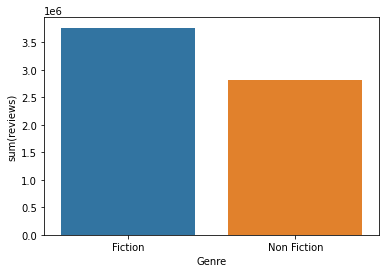

In [0]:
sns.barplot(x="Genre", y="sum(reviews)", data=books.groupBy("Genre").agg({"reviews": "sum"}).toPandas())

In [0]:
for_corr = books["Rating", "Reviews", "Price"].selectExpr(
    "cast(Rating as float) Rating", 
    "cast(Reviews as int) Reviews", 
    "cast(Price as int) Price"
)
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=for_corr.columns, outputCol=vector_col)
books_vector = assembler.transform(for_corr).select(vector_col)
matrix = Correlation.corr(books_vector, vector_col)
matrix.collect()[0]["pearson({})".format(vector_col)].values

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[6]: array([ 1.        , -0.00172901, -0.13308631, -0.00172901,  1.        ,
       -0.10918188, -0.13308631, -0.10918188,  1.        ])

Out[9]: <seaborn.axisgrid.PairGrid at 0x7f375c1edb20>

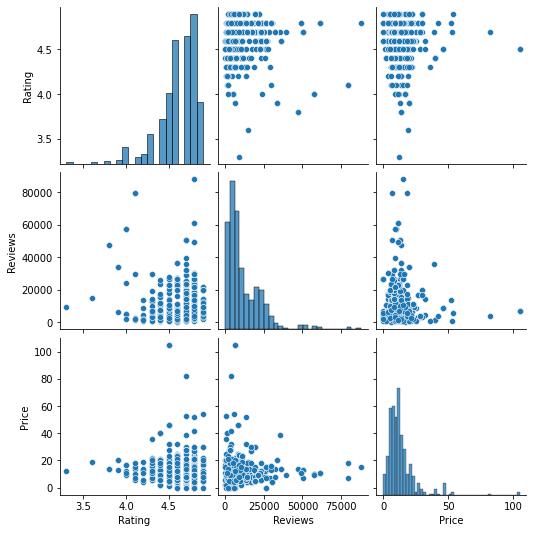

In [0]:
sns.pairplot(for_corr.toPandas())

In [0]:
books.createOrReplaceTempView("books")
spark.sql("SELECT Author, avg(Rating) as author_rating FROM books GROUP BY Author ORDER BY author_rating DESC LIMIT 1").show()

+----------+-------------+
|    Author|author_rating|
+----------+-------------+
|Jill Twiss|          4.9|
+----------+-------------+



In [0]:
spark.sql("SELECT Author, avg(Rating) as author_rating FROM books GROUP BY Author ORDER BY author_rating ASC LIMIT 3").show()

+--------------+-------------+
|        Author|author_rating|
+--------------+-------------+
|   Donna Tartt|          3.9|
| Gillian Flynn|          4.0|
|Muriel Barbery|          4.0|
+--------------+-------------+



In [0]:
spark.sql("SELECT Author, sum(Reviews) as author_revs FROM books GROUP BY Author ORDER BY author_revs DESC LIMIT 1").show()

+---------------+-----------+
|         Author|author_revs|
+---------------+-----------+
|Suzanne Collins|   278329.0|
+---------------+-----------+



In [0]:
spark.sql("SELECT Author, count(Name) as books_amount FROM books GROUP BY Author ORDER BY books_amount DESC LIMIT 1").show()

+-----------+------------+
|     Author|books_amount|
+-----------+------------+
|Jeff Kinney|          12|
+-----------+------------+



In [0]:
spark.sql("SELECT Name, Rating, Genre FROM books WHERE Genre == 'Fiction' ORDER BY Rating ASC LIMIT 1").show()

+------------------+------+-------+
|              Name|Rating|  Genre|
+------------------+------+-------+
|The Casual Vacancy|   3.3|Fiction|
+------------------+------+-------+



In [0]:
spark.sql("SELECT Name, Rating, Genre FROM books WHERE Genre == 'Non Fiction' ORDER BY Rating DESC LIMIT 1").show()

+--------------------+------+-----------+
|                Name|Rating|      Genre|
+--------------------+------+-----------+
|Hamilton: The Rev...|   4.9|Non Fiction|
+--------------------+------+-----------+



Out[43]: <AxesSubplot:xlabel='Year', ylabel='year_reviews'>

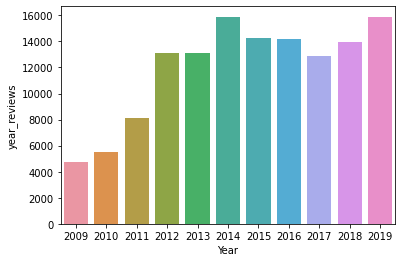

In [0]:
year_revs = spark.sql("SELECT Year, avg(Reviews) as year_reviews FROM books GROUP BY Year ORDER BY Year")
sns.barplot(x="Year", y="year_reviews", data=year_revs.toPandas())

Out[44]: <AxesSubplot:xlabel='Genre', ylabel='count(Name)'>

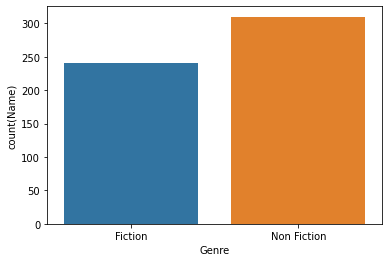

In [0]:
sns.barplot(x="Genre", y="count(Name)", data=books.groupBy("Genre").agg({"Name": "count"}).toPandas())